In [ ]:
Name:Suman Kumar Sahu

Dataset:
Status:

Objective:(continued)Principle Component Analysis

In [2]:
from pyspark.sql import SparkSession

spark=SparkSession\
.builder\
.appName('Effect of dimensionality reduction on prediction')\
.getOrCreate()

rawData=spark.read\
.format('csv')\
.option('header','true')\
.load("/home/titan/dataset/ML_JRVI/day.csv")

In [3]:
rawData.toPandas().head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869,82,1518,1600


In [4]:
from pyspark.sql.functions import col
dataset=rawData.select(col('season').cast('float'),
                      col('yr').cast('float'),
                      col('mnth').cast('float'),
                      col('holiday').cast('float'),
                      col('weekday').cast('float'),
                      col('workingday').cast('float'),
                      col('weathersit').cast('float'),
                      col('temp').cast('float'),
                      col('atemp').cast('float'),
                      col('hum').cast('float'),
                      col('windspeed').cast('float'),
                      col('cnt').cast('float')
                      )

dataset.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0
3,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0
4,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0


In [5]:
dataset=dataset.replace('?',None).dropna(how='any')

In [7]:
dataset.count()

731

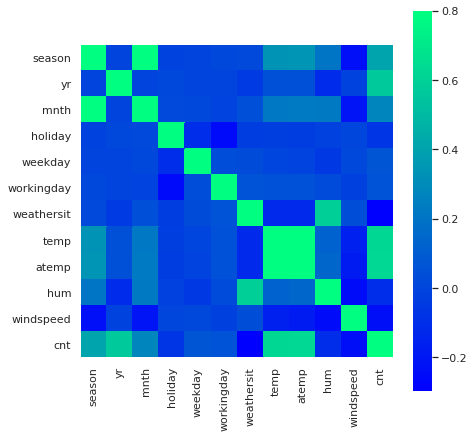

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
corrmat=dataset.toPandas().corr()
plt.figure(figsize=(7,7))
sns.set(font_scale=1.0)
sns.heatmap(corrmat,vmax=.8,square=True,fmt='.2f', cmap='winter')
plt.show()

In [9]:
featureCols=dataset.columns.copy()
featureCols.remove('cnt')
featureCols

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [14]:
from pyspark.ml.feature import VectorAssembler

assembler= VectorAssembler(inputCols=featureCols,
                           outputCol='features')

In [15]:
vectorDF=assembler.transform(dataset)
vectorDF.toPandas().head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,features
0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0,"[1.0, 0.0, 1.0, 0.0, 6.0, 0.0, 2.0, 0.34416699..."
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.36347800..."


In [16]:
(trainingData,testData)=vectorDF.randomSplit([0.8,0.2])

In [18]:
from pyspark.ml.regression import LinearRegression
lr= LinearRegression(maxIter=100,
                    regParam=1.0,
                    elasticNetParam=0.8,
                    labelCol='cnt',
                    featuresCol='features')

In [19]:
model=lr.fit(trainingData)

In [20]:
print("Training R^2 score",model.summary.r2)
print("Training RMSE =", model.summary.rootMeanSquaredError)

Training R^2 score 0.7941293626385513
Training RMSE = 865.8024551288175


In [21]:
predictions=model.transform(testData)
predictions.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,features,prediction
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.216522,0.250322,0.722174,0.073983,1096.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.21652199...",1658.532578
1,1.0,0.0,1.0,0.0,2.0,1.0,2.0,0.169091,0.191464,0.686364,0.122132,1263.0,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.16909100...",1033.898226
2,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.172727,0.160473,0.599545,0.304627,1162.0,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.17272700...",1256.818327
3,1.0,0.0,1.0,0.0,5.0,1.0,1.0,0.177500,0.157833,0.457083,0.353242,1543.0,"[1.0, 0.0, 1.0, 0.0, 5.0, 1.0, 1.0, 0.17749999...",1387.525160
4,1.0,0.0,1.0,0.0,5.0,1.0,2.0,0.196522,0.208839,0.498696,0.168726,1510.0,"[1.0, 0.0, 1.0, 0.0, 5.0, 1.0, 2.0, 0.19652199...",1386.605948


In [30]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(
labelCol='cnt',
predictionCol='prediction',
metricName='r2')

rsquare=evaluator.evaluate(predictions)
print("Test r2 score = %g"% rsquare)

Test r2 score = 0.812493


In [33]:
evaluator=RegressionEvaluator(
labelCol='cnt',
predictionCol='prediction',
metricName='rmse')

rmse=evaluator.evaluate(predictions)
print("Test rmse score = %g"% rmse)

Test r2 score = 880.615


In [34]:
predictionsPandas=predictions.toPandas()


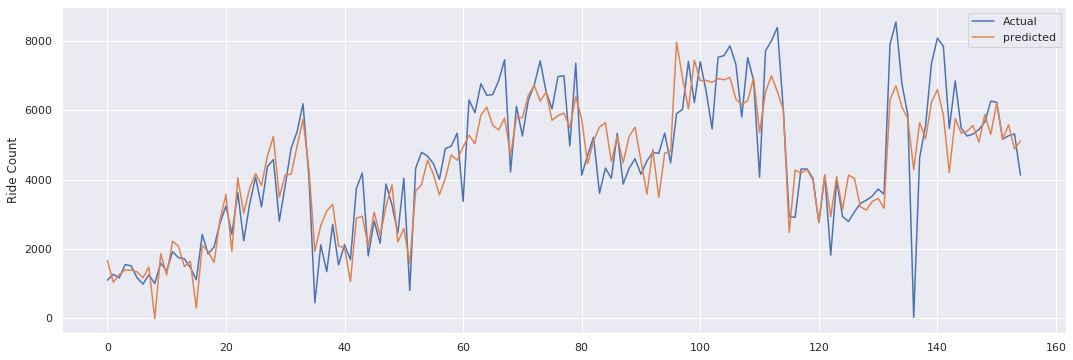

In [36]:
plt.figure(figsize=(18,6))

plt.plot(predictionsPandas['cnt'],label='Actual')
plt.plot(predictionsPandas['prediction'],label='predicted')

plt.ylabel('Ride Count')
plt.legend()

plt.show()

#### Performing Dimensionality Reduction

In [39]:
from pyspark.ml.feature import PCA
pca= PCA(k=8,
        inputCol='features',
        outputCol='pcaFeatures')

In [40]:
pcaTransformer=pca.fit(vectorDF)

In [41]:
pcaFeatureData=pcaTransformer.transform(vectorDF).select('pcaFeatures')
pcaFeatureData.toPandas().head(2)

,pcaFeatures
0,"[-1.2994341051211544, -6.000295788252946, 0.38..."
1,"[-1.256074046605144, -0.0018090609273901468, 0..."


In [42]:
pcaFeatureData.toPandas()['pcaFeatures'][0]

DenseVector([-1.2994, -6.0003, 0.3846, -2.024, 0.458, -0.4848, 0.569, -0.0731])

In [44]:
pcaTransformer.explainedVariance

DenseVector([0.7093, 0.2227, 0.0201, 0.0171, 0.0137, 0.0119, 0.0028, 0.0014])

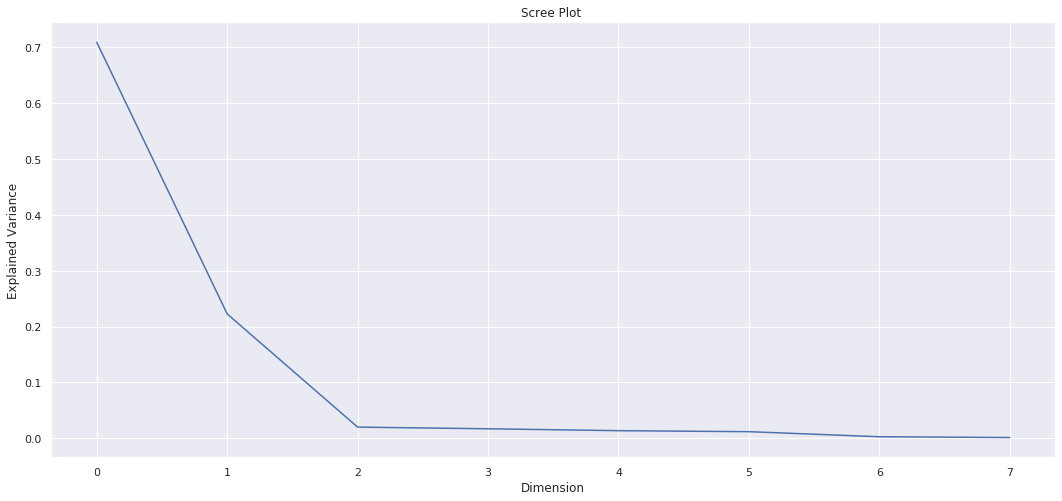

In [47]:
plt.figure(figsize=(18,8))

plt.plot(pcaTransformer.explainedVariance)
plt.xlabel('Dimension')
plt.ylabel('Explained Variance')
plt.title('Scree Plot ')
plt.show()

In [49]:
from pyspark.sql.functions import monotonically_increasing_id

pcaFeatureData= pcaFeatureData.withColumn('row_index',monotonically_increasing_id())
vectorDF=vectorDF.withColumn('row_index',monotonically_increasing_id())

In [50]:
transformedData=pcaFeatureData.join(vectorDF,on=['row_index']).sort('row_index').select('cnt','pcaFeatures')
transformedData.toPandas().head()
                                                                                       

,cnt,pcaFeatures
0,985.0,"[-1.2994341051211544, -6.000295788252946, 0.38..."
1,801.0,"[-1.256074046605144, -0.0018090609273901468, 0..."
2,1349.0,"[-1.2498374389125808, -1.0026992468169056, 0.5..."
3,1562.0,"[-1.2589193782131007, -2.0018604800043334, 0.5..."
4,1600.0,"[-1.264951594573436, -3.0022673722336357, 0.58..."


In [58]:
(pcatrainingData,pcatestData)=transformedData.randomSplit([0.8,0.2])
# pcatrainingData.head(3)

[Row(cnt=22.0, pcaFeatures=DenseVector([-10.7434, -0.9475, 0.7172, -2.9706, 1.7586, 0.2508, 0.4435, -0.1358])),
 Row(cnt=441.0, pcaFeatures=DenseVector([-11.8825, -2.9623, -2.6265, -2.2959, 1.7206, 0.5292, 0.5544, -0.1084])),
 Row(cnt=506.0, pcaFeatures=DenseVector([-1.281, -3.0187, 0.1847, -3.1666, 0.7922, 0.3199, 0.3771, -0.1531]))]

In [61]:
pcalr= LinearRegression(maxIter=100,
                    regParam=1.0,
                    elasticNetParam=0.8,
                    labelCol='cnt',
                    featuresCol='pcaFeatures')

In [62]:
pcaModel=pcalr.fit(pcatrainingData)

In [74]:
pcapredictions=pcaModel.transform(pcatestData)
pcapredictionsPandas=pcapredictions.toPandas().head()

In [75]:
print("Training R^2 score",pcaModel.summary.r2)
print("Training RMSE =", pcaModel.summary.rootMeanSquaredError)

Training R^2 score 0.7839755685441456
Training RMSE = 895.0955242648886


In [76]:
evaluator=RegressionEvaluator(
labelCol='cnt',
predictionCol='prediction',
metricName='r2')

rsquare=evaluator.evaluate(pcapredictions)
print("Test r2 score = %g"% rsquare)

Test r2 score = 0.808206


In [77]:
evaluator=RegressionEvaluator(
labelCol='cnt',
predictionCol='prediction',
metricName='rmse')

rmse=evaluator.evaluate(pcapredictions)
print("Test r2 score = %g"% rmse)

Test r2 score = 864.349


In [79]:
pcapredictionsPandas.columns

Index(['cnt', 'pcaFeatures', 'prediction'], dtype='object')

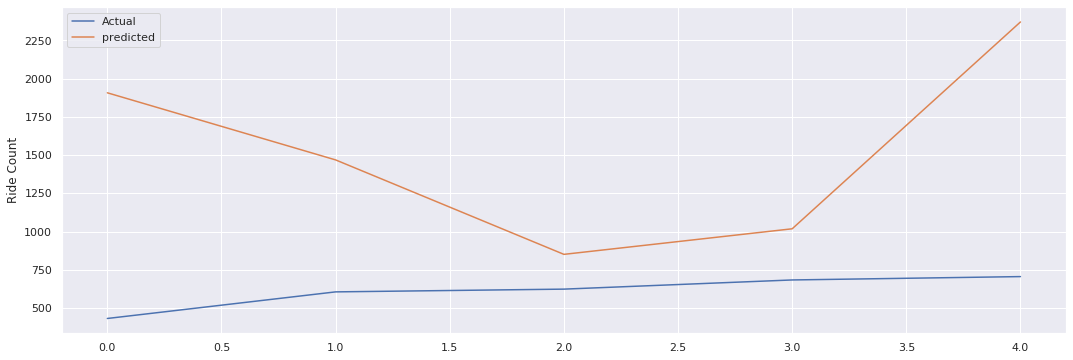

In [78]:
#Check the correctness of these statements


plt.figure(figsize=(18,6))

plt.plot(pcapredictionsPandas['cnt'],label='Actual')
plt.plot(pcapredictionsPandas['prediction'],label='predicted')

plt.ylabel('Ride Count')
plt.legend()

plt.show()